In [2]:
import numpy as np # matrix tools
import matplotlib.pyplot as plt # for basic plots
import seaborn as sns # for nicer plots
import pandas as pd
from glob import glob
import re
from skimage.io import imread

import keras

/home/hsinfu/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper
2022-04-13 12:26:10.569569: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-13 12:26:10.569681: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
overview = pd.read_csv('overview.csv')

overview.head()

,Unnamed: 0,Age,Contrast,ContrastTag,raw_input_path,id,tiff_name,dicom_name
0,0,60,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (1).dcm,0,ID_0000_AGE_0060_CONTRAST_1_CT.tif,ID_0000_AGE_0060_CONTRAST_1_CT.dcm
1,1,69,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (10).dcm,1,ID_0001_AGE_0069_CONTRAST_1_CT.tif,ID_0001_AGE_0069_CONTRAST_1_CT.dcm
2,2,74,True,APPLIED,../data/50_50_dicom_cases\Contrast\00001 (11).dcm,2,ID_0002_AGE_0074_CONTRAST_1_CT.tif,ID_0002_AGE_0074_CONTRAST_1_CT.dcm
3,3,75,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (12).dcm,3,ID_0003_AGE_0075_CONTRAST_1_CT.tif,ID_0003_AGE_0075_CONTRAST_1_CT.dcm
4,4,56,True,NONE,../data/50_50_dicom_cases\Contrast\00001 (13).dcm,4,ID_0004_AGE_0056_CONTRAST_1_CT.tif,ID_0004_AGE_0056_CONTRAST_1_CT.dcm


In [11]:
all_images_list = glob(os.path.join('tiff_images','*.tif'))



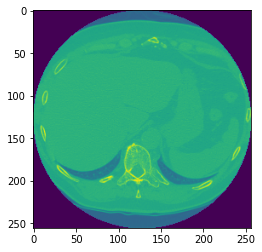

In [56]:
jimread = lambda x: np.expand_dims(imread(x)[::2,::2],0)
test_image = jimread(all_images_list[0])
plt.imshow(test_image[0])

In [42]:
type(test_image[0])


numpy.ndarray

In [14]:
check_contrast = re.compile(r'ID_([\d]+)_AGE_[\d]+_CONTRAST_([\d]+)_CT')
label = []
id_list = []
for image in all_images_list:
    id_list.append(check_contrast.findall(image)[0][0])
    label.append(check_contrast.findall(image)[0][1])

In [15]:
label_list = pd.DataFrame(label,id_list)

In [16]:
label_list.head()

,0
0074,0
0036,1
0068,0
0034,1
0035,1


In [17]:
images = np.stack([jimread(i) for i in all_images_list],0)

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, label_list, test_size=0.1, random_state=0)

In [20]:
n_train, depth, width, height = X_train.shape
n_test,_,_,_ = X_test.shape

input_shape = (width,height,depth)

input_train = X_train.reshape((n_train, width,height,depth))
input_train.shape
input_train.astype('float32')
input_train = input_train / np.max(input_train)


In [22]:
from keras.utils import np_utils


input_test = X_test.reshape(n_test, *input_shape)
input_test.astype('float32')
input_test = input_test / np.max(input_test)

output_train = keras.utils.np_utils.to_categorical(y_train, 2)
output_test = keras.utils.np_utils.to_categorical(y_test, 2)


In [30]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D



In [32]:
model = Sequential()

model.add(Conv2D(50, (5, 5), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(3, 3))) 

model.add(Conv2D(30, (4, 4), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2))) 

model.add(Flatten()) 
model.add(Dense(2, activation='softmax'))

In [33]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [34]:
model.fit(input_train, output_train,
            batch_size=20,
            epochs=20,
            verbose=1,
            validation_data=(input_test, output_test))

Epoch 1/20
5/5 [==============================] - 9s 2s/step - loss: 0.7093 - accuracy: 0.5444 - val_loss: 0.7410 - val_accuracy: 0.4000
Epoch 2/20
5/5 [==============================] - 7s 1s/step - loss: 0.6423 - accuracy: 0.5111 - val_loss: 0.6842 - val_accuracy: 0.4000
Epoch 3/20
5/5 [==============================] - 8s 2s/step - loss: 0.5595 - accuracy: 0.6778 - val_loss: 0.6856 - val_accuracy: 0.6000
Epoch 4/20
5/5 [==============================] - 7s 1s/step - loss: 0.4333 - accuracy: 0.8333 - val_loss: 0.6274 - val_accuracy: 0.8000
Epoch 5/20
5/5 [==============================] - 7s 1s/step - loss: 0.2582 - accuracy: 0.9111 - val_loss: 1.2229 - val_accuracy: 0.5000
Epoch 6/20
5/5 [==============================] - 7s 1s/step - loss: 0.2182 - accuracy: 0.8667 - val_loss: 0.8284 - val_accuracy: 0.7000
Epoch 7/20
5/5 [==============================] - 7s 1s/step - loss: 0.2433 - accuracy: 0.8889 - val_loss: 1.5232 - val_accuracy: 0.7000
Epoch 8/20
5/5 [=========================

In [35]:
model.save('model.h5')  # creates a HDF5 file 'model.h5'

In [36]:
model.predict(input_test)

array([[2.7782005e-01, 7.2218001e-01],
       [9.6647102e-01, 3.3528928e-02],
       [9.8538637e-01, 1.4613597e-02],
       [5.7727255e-13, 1.0000000e+00],
       [5.8636433e-01, 4.1363573e-01],
       [9.9721551e-01, 2.7845083e-03],
       [8.4716241e-08, 9.9999988e-01],
       [9.8137569e-01, 1.8624293e-02],
       [5.8015103e-06, 9.9999416e-01],
       [9.9051499e-01, 9.4849691e-03]], dtype=float32)